# Notebook 3 - Machine Learning classification models

On essaiera trois modèles :
- La régression logistique : modèle le plus simple, explicable via ses coefficients, mais potentiellement trop simple pour pouvoir capturer les relations potentiellement complexes entre nos variables
- Le random forest : modèle un peu plus sophistiqué, explicable, 
- Un réseau de neuronnes : modèle plus complexe, mais non explicable sans SHAP

### On importe les librairies nécessaires

In [19]:
import pandas as pd
import numpy as np
from scipy.stats import randint
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.stats import randint
import shap
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
########### Machine learning libraries and functions
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, make_scorer, recall_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

########### Deep learning with Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

### On importe les librairies nécessaires

In [ ]:
df = pd.read_csv("12M_trans/AML_features.csv")

features = [col for col in df.columns if col not in ['IS_FRAUD', 'ACCOUNT_ID']]

### Paramètre utilisateur

In [4]:
min_recall = 0.85
min_recall_tuning = 0.825
training_size = 0.8

## General functions

In [5]:

# Dichotomy (binary search) function to find the optimal threshold
def find_optimal_threshold(y_prob, y_true, limit_recall, tol=1e-4):
    low, high = 0.0, 1.0
    best_threshold = 0.5
    while high - low > tol:
        mid = (low + high) / 2.0
        y_pred = (y_prob >= mid).astype(int)
        recall = recall_score(y_true, y_pred)
        
        if recall < limit_recall:
            high = mid
        else:
            best_threshold = mid
            low = mid
            
    return best_threshold

# Function to calculate SAR Conversion Rate
def sar_conversion_rate(y_true, y_pred):
    positive_predictions = np.sum(y_pred)
    if positive_predictions == 0:
        return 0
    true_positives = np.sum((y_pred == 1) & (y_true == 1))
    return true_positives / positive_predictions

# Custom scoring functions
def conversion_rate(y_true, y_pred):
    positive_predictions = sum(y_pred)
    if positive_predictions == 0:
        return 0
    true_positives = sum((y_true == 1) & (y_pred == 1))
    return true_positives / positive_predictions

def recall_class_1(y_true, y_pred):
    return recall_score(y_true, y_pred, pos_label=1)

# Custom weighted scoring function
def weighted_score(y_true, y_pred):
    recall = recall_class_1(y_true, y_pred)
    conversion = conversion_rate(y_true, y_pred)
    return 0.2 * recall + 0.8 * conversion


### Pre-training pre-processing 

In [6]:
# Assume X is your feature DataFrame and y is your target variable
X = df[features]
y = df["IS_FRAUD"]

# Step 1: Stratified split to create training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=(1 - training_size), stratify=y, random_state=42
)

# Step 2: Apply StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training set and transform the training set
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test set using the same scaler
X_test_scaled = scaler.transform(X_test)


# 1 - Regression logistique sans gestion du déséquilibre

Fitting 5 folds for each of 10 candidates, totalling 50 fits


C:\Users\balle\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
30 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\balle\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\balle\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\balle\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 457, in _check_solver
    raise ValueError(
Valu

Best parameters found:  {'solver': 'saga', 'penalty': 'l2', 'max_iter': 200, 'C': 545.5594781168514}
5/5 [==============================] - 0s 2ms/step
Fold 1: Objective Recall Target = 0.9576


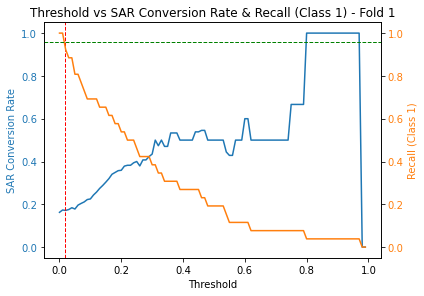

5/5 [==============================] - 0s 3ms/step
Fold 2: Objective Recall Target = 0.9414


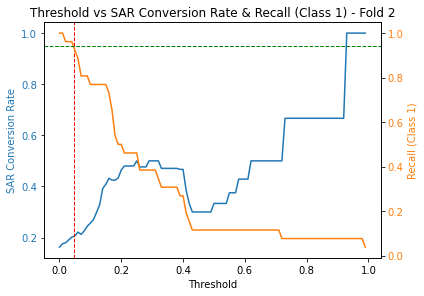

5/5 [==============================] - 0s 3ms/step
Fold 3: Objective Recall Target = 0.9025


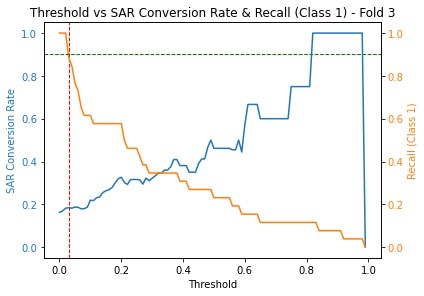

5/5 [==============================] - 0s 4ms/step
Fold 4: Objective Recall Target = 0.8857


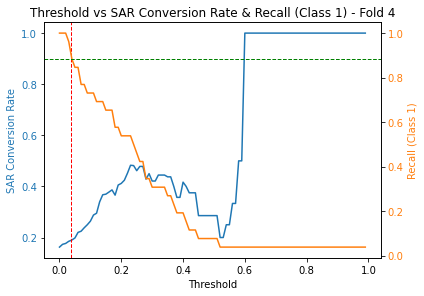

5/5 [==============================] - 0s 2ms/step
Fold 5: Objective Recall Target = 0.8626


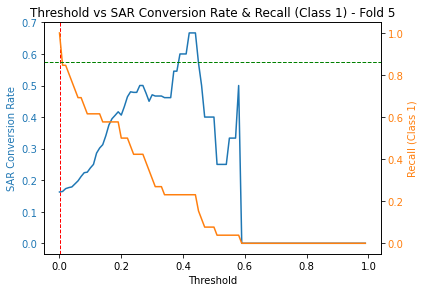

Averaged Optimal Threshold from Cross-Validation: 0.0262
7/7 [==============================] - 0s 1ms/step
Test Set SAR Conversion Rate at Averaged Threshold: 0.1722
Test Set Recall at Averaged Threshold: 0.8125


In [10]:
# Hyperparameter tuning for Logistic Regression
lr_param_dist = {
    'C': np.logspace(-4, 4, 20),  # Regularization strength
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],  # Penalty type
    'solver': ['saga', 'liblinear'],  # Solvers that handle l1/l2 regularization
    'max_iter': [100, 200, 500]  # Number of iterations
}

# Define your model
lr_model = LogisticRegression(random_state=42)

# Set up the RandomizedSearchCV
lr_random_search = RandomizedSearchCV(
    estimator=lr_model,
    param_distributions=lr_param_dist,
    n_iter=10,  # You can increase this number for a more thorough search
    scoring=recall_scorer,  # Scoring based on recall
    n_jobs=-1,
    cv=5,
    verbose=1,
    random_state=42
)

# Fit the model
lr_random_search.fit(X_train_scaled, y_train)

# Output the best parameters and the best score from RandomizedSearchCV
print("Best parameters found: ", lr_random_search.best_params_)

# Use the best model found from the RandomizedSearchCV for further steps
lr_best_model = random_search.best_estimator_

# Cross-validation setup with stratification
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
optimal_thresholds = []

# Cross-validation process
for fold_num, (train_index, val_index) in enumerate(skf.split(X_train_scaled, y_train), start=1):
    X_train_fold = X_train_scaled[train_index]
    X_val_fold = X_train_scaled[val_index]
    y_train_fold = y_train.iloc[train_index]
    y_val_fold = y_train.iloc[val_index]
    
    # Train the best model on the current fold
    lr_best_model.fit(X_train_fold, y_train_fold)
    
    # Predict probabilities on the validation fold
    y_prob_val_fold = lr_best_model.predict_proba(X_val_fold)[:, 1]
    
    # Calculate SAR Conversion Rate and Recall for each threshold
    thresholds = np.arange(0.0, 1.0, 0.01)
    sar_rates = []
    recalls = []
    for threshold in thresholds:
        y_pred_val = (y_prob_val_fold >= threshold).astype(int)
        sar_rate = conversion_rate(y_val_fold, y_pred_val)
        recall = recall_score(y_val_fold, y_pred_val)
        sar_rates.append(sar_rate)
        recalls.append(recall)
    
    objective_recall = np.random.uniform(min_recall_tuning, 1.0)
    print(f"Fold {fold_num}: Objective Recall Target = {objective_recall:.4f}")
    
    # Find the optimal threshold using the dichotomy method for this fold
    optimal_threshold = find_optimal_threshold(y_prob_val_fold, y_val_fold, objective_recall)
    optimal_thresholds.append(optimal_threshold)

    # Plot SAR Conversion Rate and Recall for each threshold
    fig, ax1 = plt.subplots()

    ax1.set_xlabel('Threshold')
    ax1.set_ylabel('SAR Conversion Rate', color='tab:blue')
    ax1.plot(thresholds, sar_rates, color='tab:blue', label='SAR Conversion Rate')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.set_ylabel('Recall (Class 1)', color='tab:orange')
    ax2.plot(thresholds, recalls, color='tab:orange', label='Recall (Class 1)')
    ax2.tick_params(axis='y', labelcolor='tab:orange')

    # Highlight the selected threshold and the objective recall
    ax1.axvline(x=optimal_threshold, color='red', linestyle='--', linewidth=1, label='Selected Threshold')
    ax2.axhline(y=objective_recall, color='green', linestyle='--', linewidth=1, label='Objective Recall')

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.title(f'Threshold vs SAR Conversion Rate & Recall (Class 1) - Fold {fold_num}')
    plt.show()

# Average the thresholds obtained from all folds
average_threshold = np.mean(optimal_thresholds)
print(f"Averaged Optimal Threshold from Cross-Validation: {average_threshold:.4f}")

# Evaluate on the test set using the averaged threshold
y_prob_test = best_model.predict_proba(X_test_scaled)[:, 1]
y_pred_test = (y_prob_test >= average_threshold).astype(int)
test_sar_conversion = conversion_rate(y_test, y_pred_test)
test_recall = recall_score(y_test, y_pred_test)

print(f"Test Set SAR Conversion Rate at Averaged Threshold: {test_sar_conversion:.4f}")
print(f"Test Set Recall at Averaged Threshold: {test_recall:.4f}")

In [11]:
# Attention, cette étape dure un certain temps

lr_explainer = shap.Explainer(lr_best_model.predict,X_test_scaled[:100])
lr_shap_values_test = explainer(X_test_scaled[:100])

84/84 [==============================] - 0s 975us/step


PermutationExplainer explainer:   4%|██▎                                                       | 4/100 [00:00<?, ?it/s]

84/84 [==============================] - 0s 2ms/step


PermutationExplainer explainer:   6%|███                                               | 6/100 [00:13<01:51,  1.18s/it]

83/83 [==============================] - 0s 988us/step


PermutationExplainer explainer:   7%|███▌                                              | 7/100 [00:15<02:30,  1.62s/it]

81/81 [==============================] - 0s 1ms/step


PermutationExplainer explainer:   8%|████                                              | 8/100 [00:17<02:47,  1.82s/it]

83/83 [==============================] - 0s 973us/step


PermutationExplainer explainer:   9%|████▌                                             | 9/100 [00:20<03:08,  2.08s/it]

83/83 [==============================] - 0s 910us/step


PermutationExplainer explainer:  10%|████▉                                            | 10/100 [00:22<03:11,  2.13s/it]

84/84 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  11%|█████▍                                           | 11/100 [00:25<03:25,  2.31s/it]

84/84 [==============================] - 0s 1ms/step


PermutationExplainer explainer:  12%|█████▉                                           | 12/100 [00:28<03:33,  2.43s/it]

84/84 [==============================] - 0s 1ms/step


PermutationExplainer explainer:  13%|██████▎                                          | 13/100 [00:30<03:43,  2.57s/it]

82/82 [==============================] - 0s 1ms/step


PermutationExplainer explainer:  14%|██████▊                                          | 14/100 [00:33<03:43,  2.60s/it]

83/83 [==============================] - 0s 1ms/step


PermutationExplainer explainer:  15%|███████▎                                         | 15/100 [00:35<03:35,  2.54s/it]

83/83 [==============================] - 0s 1ms/step


PermutationExplainer explainer:  16%|███████▊                                         | 16/100 [00:38<03:33,  2.54s/it]

84/84 [==============================] - 0s 931us/step


PermutationExplainer explainer:  17%|████████▎                                        | 17/100 [00:40<03:27,  2.50s/it]

81/81 [==============================] - 0s 962us/step


PermutationExplainer explainer:  18%|████████▊                                        | 18/100 [00:43<03:30,  2.57s/it]

83/83 [==============================] - 0s 1ms/step


PermutationExplainer explainer:  19%|█████████▎                                       | 19/100 [00:46<03:23,  2.51s/it]

82/82 [==============================] - 0s 1ms/step


PermutationExplainer explainer:  20%|█████████▊                                       | 20/100 [00:48<03:17,  2.47s/it]

84/84 [==============================] - 0s 1ms/step


PermutationExplainer explainer:  21%|██████████▎                                      | 21/100 [00:51<03:38,  2.76s/it]

84/84 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  22%|██████████▊                                      | 22/100 [00:54<03:43,  2.87s/it]

81/81 [==============================] - 0s 999us/step


PermutationExplainer explainer:  23%|███████████▎                                     | 23/100 [00:57<03:33,  2.77s/it]

81/81 [==============================] - 0s 1ms/step


PermutationExplainer explainer:  24%|███████████▊                                     | 24/100 [00:59<03:24,  2.69s/it]

83/83 [==============================] - 0s 1ms/step


PermutationExplainer explainer:  25%|████████████▎                                    | 25/100 [01:02<03:14,  2.59s/it]

83/83 [==============================] - 0s 977us/step


PermutationExplainer explainer:  26%|████████████▋                                    | 26/100 [01:04<03:11,  2.59s/it]

84/84 [==============================] - 0s 1ms/step


PermutationExplainer explainer:  27%|█████████████▏                                   | 27/100 [01:07<03:08,  2.58s/it]

81/81 [==============================] - 0s 1ms/step


PermutationExplainer explainer:  28%|█████████████▋                                   | 28/100 [01:09<03:01,  2.52s/it]

84/84 [==============================] - 0s 926us/step


PermutationExplainer explainer:  29%|██████████████▏                                  | 29/100 [01:12<02:57,  2.50s/it]

84/84 [==============================] - 0s 1ms/step


PermutationExplainer explainer:  30%|██████████████▋                                  | 30/100 [01:14<02:56,  2.52s/it]

80/80 [==============================] - 0s 990us/step


PermutationExplainer explainer:  31%|███████████████▏                                 | 31/100 [01:17<02:53,  2.51s/it]

81/81 [==============================] - 0s 1ms/step


PermutationExplainer explainer:  32%|███████████████▋                                 | 32/100 [01:19<02:44,  2.42s/it]

81/81 [==============================] - 0s 1ms/step


PermutationExplainer explainer:  33%|████████████████▏                                | 33/100 [01:22<02:42,  2.42s/it]

83/83 [==============================] - 0s 999us/step


PermutationExplainer explainer:  34%|████████████████▋                                | 34/100 [01:24<02:35,  2.36s/it]

84/84 [==============================] - 0s 892us/step


PermutationExplainer explainer:  35%|█████████████████▏                               | 35/100 [01:26<02:34,  2.38s/it]

83/83 [==============================] - 0s 1ms/step


PermutationExplainer explainer:  36%|█████████████████▋                               | 36/100 [01:29<02:31,  2.37s/it]

84/84 [==============================] - 0s 956us/step


PermutationExplainer explainer:  37%|██████████████████▏                              | 37/100 [01:31<02:28,  2.35s/it]

82/82 [==============================] - 0s 933us/step


PermutationExplainer explainer:  38%|██████████████████▌                              | 38/100 [01:33<02:23,  2.31s/it]

84/84 [==============================] - 0s 1ms/step


PermutationExplainer explainer:  39%|███████████████████                              | 39/100 [01:35<02:20,  2.30s/it]

84/84 [==============================] - 0s 909us/step


PermutationExplainer explainer:  40%|███████████████████▌                             | 40/100 [01:38<02:20,  2.34s/it]

83/83 [==============================] - 0s 975us/step


PermutationExplainer explainer:  41%|████████████████████                             | 41/100 [01:40<02:18,  2.35s/it]

84/84 [==============================] - 0s 1ms/step


PermutationExplainer explainer:  42%|████████████████████▌                            | 42/100 [01:43<02:20,  2.42s/it]

84/84 [==============================] - 0s 1ms/step


PermutationExplainer explainer:  43%|█████████████████████                            | 43/100 [01:45<02:20,  2.46s/it]

84/84 [==============================] - 0s 963us/step


PermutationExplainer explainer:  44%|█████████████████████▌                           | 44/100 [01:48<02:21,  2.53s/it]

84/84 [==============================] - 0s 963us/step


PermutationExplainer explainer:  45%|██████████████████████                           | 45/100 [01:50<02:18,  2.52s/it]

84/84 [==============================] - 0s 937us/step


PermutationExplainer explainer:  46%|██████████████████████▌                          | 46/100 [01:53<02:16,  2.53s/it]

79/79 [==============================] - 0s 907us/step


PermutationExplainer explainer:  47%|███████████████████████                          | 47/100 [01:55<02:12,  2.49s/it]

84/84 [==============================] - 0s 1ms/step


PermutationExplainer explainer:  48%|███████████████████████▌                         | 48/100 [01:58<02:07,  2.45s/it]

83/83 [==============================] - 0s 1ms/step


PermutationExplainer explainer:  49%|████████████████████████                         | 49/100 [02:00<02:04,  2.44s/it]

84/84 [==============================] - 0s 963us/step


PermutationExplainer explainer:  50%|████████████████████████▌                        | 50/100 [02:03<02:01,  2.43s/it]

84/84 [==============================] - 0s 1ms/step


PermutationExplainer explainer:  51%|████████████████████████▉                        | 51/100 [02:05<02:00,  2.47s/it]

84/84 [==============================] - 0s 1ms/step


PermutationExplainer explainer:  52%|█████████████████████████▍                       | 52/100 [02:08<01:57,  2.44s/it]

83/83 [==============================] - 0s 973us/step


PermutationExplainer explainer:  53%|█████████████████████████▉                       | 53/100 [02:10<01:50,  2.35s/it]

80/80 [==============================] - 0s 801us/step


PermutationExplainer explainer:  54%|██████████████████████████▍                      | 54/100 [02:12<01:46,  2.31s/it]

83/83 [==============================] - 0s 859us/step


PermutationExplainer explainer:  55%|██████████████████████████▉                      | 55/100 [02:14<01:42,  2.28s/it]

84/84 [==============================] - 0s 963us/step


PermutationExplainer explainer:  56%|███████████████████████████▍                     | 56/100 [02:16<01:41,  2.30s/it]

84/84 [==============================] - 0s 1ms/step


PermutationExplainer explainer:  57%|███████████████████████████▉                     | 57/100 [02:19<01:43,  2.41s/it]

83/83 [==============================] - 0s 930us/step


PermutationExplainer explainer:  58%|████████████████████████████▍                    | 58/100 [02:21<01:38,  2.34s/it]

83/83 [==============================] - 0s 886us/step


PermutationExplainer explainer:  59%|████████████████████████████▉                    | 59/100 [02:23<01:33,  2.29s/it]

84/84 [==============================] - 0s 934us/step


PermutationExplainer explainer:  60%|█████████████████████████████▍                   | 60/100 [02:26<01:33,  2.35s/it]

84/84 [==============================] - 0s 1ms/step


PermutationExplainer explainer:  61%|█████████████████████████████▉                   | 61/100 [02:28<01:32,  2.36s/it]

83/83 [==============================] - 0s 943us/step


PermutationExplainer explainer:  62%|██████████████████████████████▍                  | 62/100 [02:30<01:26,  2.29s/it]

84/84 [==============================] - 0s 862us/step


PermutationExplainer explainer:  63%|██████████████████████████████▊                  | 63/100 [02:33<01:23,  2.24s/it]

81/81 [==============================] - 0s 900us/step


PermutationExplainer explainer:  64%|███████████████████████████████▎                 | 64/100 [02:35<01:22,  2.28s/it]

83/83 [==============================] - 0s 856us/step


PermutationExplainer explainer:  65%|███████████████████████████████▊                 | 65/100 [02:37<01:19,  2.28s/it]

82/82 [==============================] - 0s 1ms/step


PermutationExplainer explainer:  66%|████████████████████████████████▎                | 66/100 [02:39<01:16,  2.26s/it]

83/83 [==============================] - 0s 1ms/step


PermutationExplainer explainer:  67%|████████████████████████████████▊                | 67/100 [02:42<01:14,  2.27s/it]

84/84 [==============================] - 0s 1ms/step


PermutationExplainer explainer:  68%|█████████████████████████████████▎               | 68/100 [02:45<01:17,  2.43s/it]

83/83 [==============================] - 0s 893us/step


PermutationExplainer explainer:  69%|█████████████████████████████████▊               | 69/100 [02:47<01:15,  2.43s/it]

83/83 [==============================] - 0s 1ms/step


PermutationExplainer explainer:  70%|██████████████████████████████████▎              | 70/100 [02:49<01:12,  2.42s/it]

84/84 [==============================] - 0s 940us/step


PermutationExplainer explainer:  71%|██████████████████████████████████▊              | 71/100 [02:53<01:20,  2.77s/it]

84/84 [==============================] - 0s 1ms/step


PermutationExplainer explainer:  72%|███████████████████████████████████▎             | 72/100 [02:56<01:18,  2.79s/it]

82/82 [==============================] - 0s 987us/step


PermutationExplainer explainer:  73%|███████████████████████████████████▊             | 73/100 [02:58<01:12,  2.69s/it]

83/83 [==============================] - 0s 824us/step


PermutationExplainer explainer:  74%|████████████████████████████████████▎            | 74/100 [03:01<01:06,  2.57s/it]

84/84 [==============================] - 0s 935us/step


PermutationExplainer explainer:  75%|████████████████████████████████████▊            | 75/100 [03:03<01:03,  2.55s/it]

83/83 [==============================] - 0s 4ms/step


PermutationExplainer explainer:  76%|█████████████████████████████████████▏           | 76/100 [03:06<01:03,  2.63s/it]

84/84 [==============================] - 0s 1ms/step


PermutationExplainer explainer:  77%|█████████████████████████████████████▋           | 77/100 [03:10<01:12,  3.14s/it]

84/84 [==============================] - 0s 958us/step


PermutationExplainer explainer:  78%|██████████████████████████████████████▏          | 78/100 [03:13<01:04,  2.93s/it]

83/83 [==============================] - 0s 1ms/step


PermutationExplainer explainer:  79%|██████████████████████████████████████▋          | 79/100 [03:15<00:58,  2.80s/it]

83/83 [==============================] - 0s 973us/step


PermutationExplainer explainer:  80%|███████████████████████████████████████▏         | 80/100 [03:17<00:53,  2.66s/it]

83/83 [==============================] - 0s 972us/step


PermutationExplainer explainer:  81%|███████████████████████████████████████▋         | 81/100 [03:20<00:48,  2.53s/it]

83/83 [==============================] - 0s 1ms/step


PermutationExplainer explainer:  82%|████████████████████████████████████████▏        | 82/100 [03:22<00:45,  2.52s/it]

82/82 [==============================] - 0s 976us/step


PermutationExplainer explainer:  83%|████████████████████████████████████████▋        | 83/100 [03:25<00:42,  2.47s/it]

84/84 [==============================] - 0s 1ms/step


PermutationExplainer explainer:  84%|█████████████████████████████████████████▏       | 84/100 [03:27<00:41,  2.57s/it]

82/82 [==============================] - 0s 1ms/step


PermutationExplainer explainer:  85%|█████████████████████████████████████████▋       | 85/100 [03:30<00:38,  2.57s/it]

84/84 [==============================] - 0s 1ms/step


PermutationExplainer explainer:  86%|██████████████████████████████████████████▏      | 86/100 [03:33<00:37,  2.65s/it]

84/84 [==============================] - 0s 1ms/step


PermutationExplainer explainer:  87%|██████████████████████████████████████████▋      | 87/100 [03:36<00:35,  2.72s/it]

83/83 [==============================] - 0s 951us/step


PermutationExplainer explainer:  88%|███████████████████████████████████████████      | 88/100 [03:38<00:30,  2.58s/it]

84/84 [==============================] - 0s 1ms/step


PermutationExplainer explainer:  89%|███████████████████████████████████████████▌     | 89/100 [03:40<00:28,  2.55s/it]

80/80 [==============================] - 0s 1ms/step


PermutationExplainer explainer:  90%|████████████████████████████████████████████     | 90/100 [03:43<00:24,  2.48s/it]

84/84 [==============================] - 0s 979us/step


PermutationExplainer explainer:  91%|████████████████████████████████████████████▌    | 91/100 [03:45<00:22,  2.48s/it]

84/84 [==============================] - 0s 1ms/step


PermutationExplainer explainer:  92%|█████████████████████████████████████████████    | 92/100 [03:48<00:20,  2.53s/it]

84/84 [==============================] - 0s 925us/step


PermutationExplainer explainer:  93%|█████████████████████████████████████████████▌   | 93/100 [03:50<00:17,  2.53s/it]

84/84 [==============================] - 0s 961us/step


PermutationExplainer explainer:  94%|██████████████████████████████████████████████   | 94/100 [03:53<00:15,  2.57s/it]

81/81 [==============================] - 0s 986us/step


PermutationExplainer explainer:  95%|██████████████████████████████████████████████▌  | 95/100 [03:55<00:12,  2.46s/it]

84/84 [==============================] - 0s 1ms/step


PermutationExplainer explainer:  96%|███████████████████████████████████████████████  | 96/100 [03:58<00:09,  2.46s/it]

82/82 [==============================] - 0s 992us/step


PermutationExplainer explainer:  97%|███████████████████████████████████████████████▌ | 97/100 [04:00<00:07,  2.42s/it]

83/83 [==============================] - 0s 1ms/step


PermutationExplainer explainer:  98%|████████████████████████████████████████████████ | 98/100 [04:02<00:04,  2.40s/it]

84/84 [==============================] - 0s 1ms/step


PermutationExplainer explainer:  99%|████████████████████████████████████████████████▌| 99/100 [04:05<00:02,  2.46s/it]

81/81 [==============================] - 0s 1ms/step


PermutationExplainer explainer: 100%|████████████████████████████████████████████████| 100/100 [04:07<00:00,  2.46s/it]

81/81 [==============================] - 0s 972us/step


PermutationExplainer explainer: 101it [04:10,  2.58s/it]                                                               


In [13]:
features

['num_sent',
 'total_sent',
 'avg_sent',
 'median_sent',
 'std_sent',
 'avg_duration_sent',
 'median_duration_sent',
 'std_duration_sent',
 'unique_counterparties_sent',
 'max_counterparty_percentage_sent',
 'num_received',
 'total_received',
 'avg_received',
 'median_received',
 'std_received',
 'avg_duration_received',
 'median_duration_received',
 'std_duration_received',
 'unique_counterparties_received',
 'max_counterparty_percentage_received',
 'ratio_max_contributor',
 'ratio_total_sent_received',
 'ratio_avg_sent_received',
 'ratio_num_sent_received',
 'ratio_median_sent_received',
 'ratio_std_sent_received']

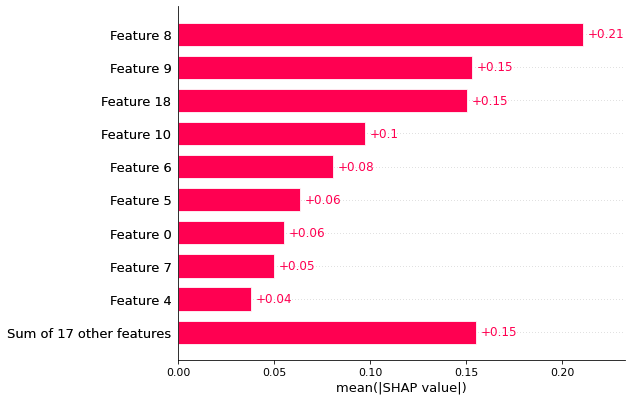

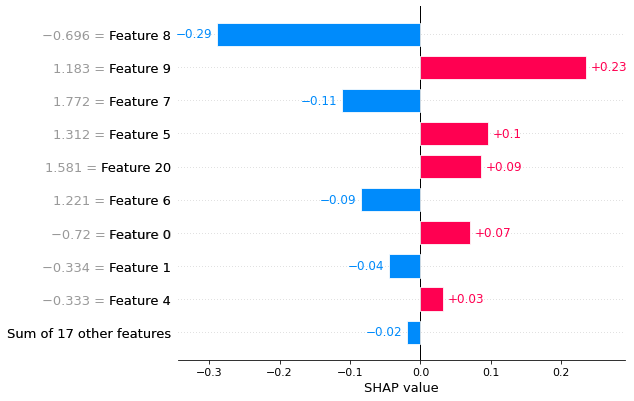

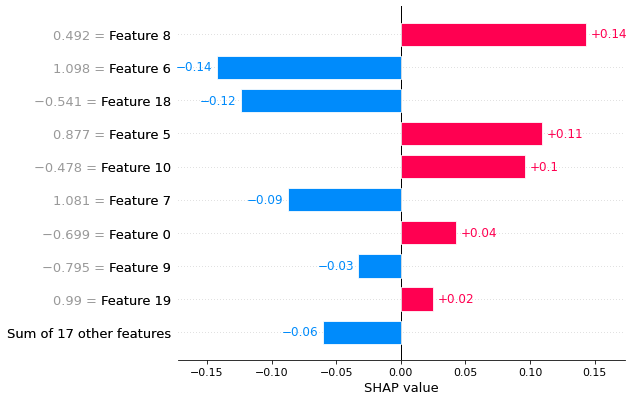

In [12]:
# Attention, cette étape dure un certain temps
shap.plots.bar(shap_values_test)
shap.plots.bar(shap_values_test[0])
shap.plots.bar(shap_values_test[1])

## 1 bis - Regression logistique avec SMOTE

Fitting 5 folds for each of 10 candidates, totalling 50 fits


C:\Users\balle\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
30 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\balle\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\balle\anaconda3\lib\site-packages\imblearn\utils\fixes.py", line 85, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\balle\anaconda3\lib\site-packages\imblearn\pipeline.py", line 333, in fit
    self._final_estimator.fit(Xt, yt, **last_step_params["fit"])
  File 

Best parameters found:  {'model__solver': 'saga', 'model__penalty': 'none', 'model__max_iter': 100, 'model__C': 1438.44988828766}


C:\Users\balle\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Fold 1: Objective Recall Target = 0.9338


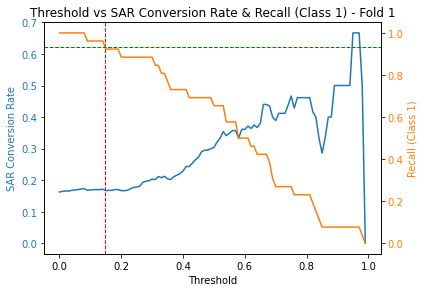

C:\Users\balle\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\balle\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Fold 2: Objective Recall Target = 0.9350


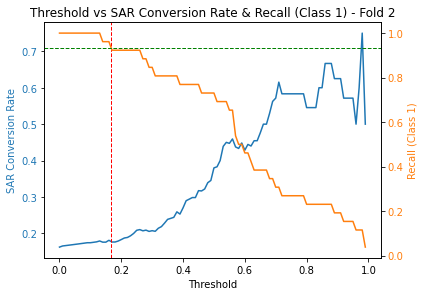

C:\Users\balle\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\balle\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Fold 3: Objective Recall Target = 0.8630


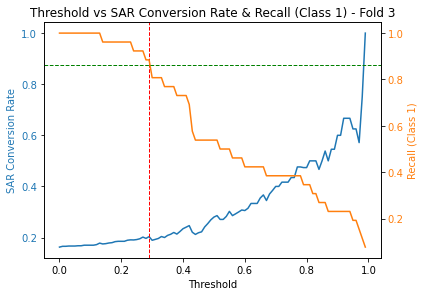

C:\Users\balle\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\balle\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Fold 4: Objective Recall Target = 0.9739


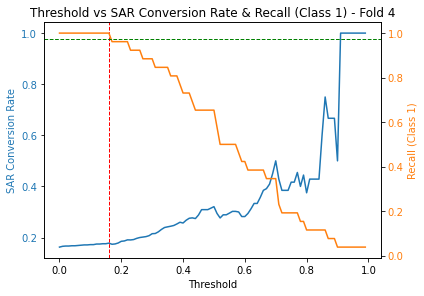

C:\Users\balle\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\balle\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Fold 5: Objective Recall Target = 0.9459


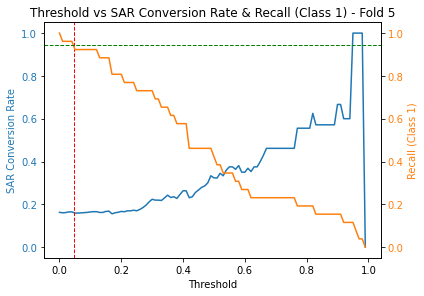

Averaged Optimal Threshold from Cross-Validation: 0.1623
Test Set SAR Conversion Rate at Averaged Threshold: 0.1636
Test Set Recall at Averaged Threshold: 0.8438


In [18]:
# Define your custom scorer based on recall
recall_scorer = make_scorer(recall_score, greater_is_better=True)

# Hyperparameter tuning for Logistic Regression
lr_param_dist = {
    'model__C': np.logspace(-4, 4, 20),  # Regularization strength
    'model__penalty': ['l1', 'l2', 'elasticnet', 'none'],  # Penalty type
    'model__solver': ['saga', 'liblinear'],  # Solvers that handle l1/l2 regularization
    'model__max_iter': [100, 200, 500]  # Number of iterations
}

# Define the pipeline that includes SMOTE and Logistic Regression
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('model', LogisticRegression(random_state=42))
])

# Set up the RandomizedSearchCV
lr_random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=lr_param_dist,
    n_iter=10,  # You can increase this number for a more thorough search
    scoring=recall_scorer,  # Scoring based on recall
    n_jobs=-1,
    cv=5,
    verbose=1,
    random_state=42
)

# Fit the model
lr_random_search.fit(X_train_scaled, y_train)

# Output the best parameters and the best score from RandomizedSearchCV
print("Best parameters found: ", lr_random_search.best_params_)

# Use the best model found from the RandomizedSearchCV for further steps
lr_best_model = lr_random_search.best_estimator_

# Cross-validation setup with stratification
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
optimal_thresholds = []

# Cross-validation process
for fold_num, (train_index, val_index) in enumerate(skf.split(X_train_scaled, y_train), start=1):
    X_train_fold = X_train_scaled[train_index]
    X_val_fold = X_train_scaled[val_index]
    y_train_fold = y_train.iloc[train_index]
    y_val_fold = y_train.iloc[val_index]
    
    # Apply SMOTE only on the training fold
    X_train_resampled, y_train_resampled = SMOTE(random_state=42).fit_resample(X_train_fold, y_train_fold)
    
    # Train the best model on the current fold with the resampled data
    lr_best_model.fit(X_train_resampled, y_train_resampled)
    
    # Predict probabilities on the validation fold
    y_prob_val_fold = lr_best_model.predict_proba(X_val_fold)[:, 1]
    
    # Calculate SAR Conversion Rate and Recall for each threshold
    thresholds = np.arange(0.0, 1.0, 0.01)
    sar_rates = []
    recalls = []
    for threshold in thresholds:
        y_pred_val = (y_prob_val_fold >= threshold).astype(int)
        sar_rate = conversion_rate(y_val_fold, y_pred_val)
        recall = recall_score(y_val_fold, y_pred_val)
        sar_rates.append(sar_rate)
        recalls.append(recall)
    
    objective_recall = np.random.uniform(min_recall_tuning, 1.0)
    print(f"Fold {fold_num}: Objective Recall Target = {objective_recall:.4f}")
    
    # Find the optimal threshold using the dichotomy method for this fold
    optimal_threshold = find_optimal_threshold(y_prob_val_fold, y_val_fold, objective_recall)
    optimal_thresholds.append(optimal_threshold)

    # Plot SAR Conversion Rate and Recall for each threshold
    fig, ax1 = plt.subplots()

    ax1.set_xlabel('Threshold')
    ax1.set_ylabel('SAR Conversion Rate', color='tab:blue')
    ax1.plot(thresholds, sar_rates, color='tab:blue', label='SAR Conversion Rate')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.set_ylabel('Recall (Class 1)', color='tab:orange')
    ax2.plot(thresholds, recalls, color='tab:orange', label='Recall (Class 1)')
    ax2.tick_params(axis='y', labelcolor='tab:orange')

    # Highlight the selected threshold and the objective recall
    ax1.axvline(x=optimal_threshold, color='red', linestyle='--', linewidth=1, label='Selected Threshold')
    ax2.axhline(y=objective_recall, color='green', linestyle='--', linewidth=1, label='Objective Recall')

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.title(f'Threshold vs SAR Conversion Rate & Recall (Class 1) - Fold {fold_num}')
    plt.show()

# Average the thresholds obtained from all folds
average_threshold = np.mean(optimal_thresholds)
print(f"Averaged Optimal Threshold from Cross-Validation: {average_threshold:.4f}")

# Evaluate on the test set using the averaged threshold
y_prob_test = lr_best_model.predict_proba(X_test_scaled)[:, 1]
y_pred_test = (y_prob_test >= average_threshold).astype(int)
test_sar_conversion = conversion_rate(y_test, y_pred_test)
test_recall = recall_score(y_test, y_pred_test)

print(f"Test Set SAR Conversion Rate at Averaged Threshold: {test_sar_conversion:.4f}")
print(f"Test Set Recall at Averaged Threshold: {test_recall:.4f}")

# 1b - Regression logistique avec méthodes de sampling

## 1b.1 - Random undersampling

In [25]:
from imblearn.under_sampling import RandomUnderSampler

# Initialize the undersampler
under_sampler = RandomUnderSampler(random_state=42)

# Apply the undersampling
X_res, y_res = under_sampler.fit_resample(X_train_standard_scaled , y_train)

# Train the logistic regression model
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_res, y_res)

# Predict probabilities for the test set
y_prob = model.predict_proba(X_test_standard_scaled )[:, 1]

# Define recall limit
limit_recall = 0.7  # Example recall limit

# Initialize lists to store SAR conversion rates and recall scores
thresholds = np.arange(0.0, 1.0, 0.01)
sar_rates = []
recalls = []

# Calculate metrics for each threshold
for threshold in thresholds:
    y_pred = (y_prob >= threshold).astype(int)
    sar_rate = sar_conversion_rate(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    
    sar_rates.append(sar_rate)
    recalls.append(recall)

# Plotting
fig, ax1 = plt.subplots()

ax1.set_xlabel('Threshold')
ax1.set_ylabel('SAR Conversion Rate', color='tab:blue')
ax1.plot(thresholds, sar_rates, color='tab:blue', label='SAR Conversion Rate')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Recall (Class 1)', color='tab:orange')
ax2.plot(thresholds, recalls, color='tab:orange', label='Recall (Class 1)')
ax2.tick_params(axis='y', labelcolor='tab:orange')

# Add the recall limit line
ax2.axhline(y=limit_recall, color='red', linestyle='--', linewidth=1, label='Recall Limit')

fig.tight_layout()
plt.title('Threshold vs SAR Conversion Rate & Recall (Class 1) - Under-Sampling')
plt.show()

# Find and print the optimal threshold and corresponding SAR Conversion Rate
optimal_threshold = find_optimal_threshold(y_prob, y_test, limit_recall)

# Calculate the SAR Conversion Rate for the optimal threshold
y_pred_optimal = (y_prob >= optimal_threshold).astype(int)
optimal_sar = sar_conversion_rate(y_test, y_pred_optimal)

print(f"Optimal Threshold for Recall Limit {limit_recall}: {optimal_threshold:.4f}")
print(f"SAR Conversion Rate at Optimal Threshold: {optimal_sar:.4f}")

NameError: name 'X_train_standard_scaled' is not defined

## 1b.2 - Synthetic Minority Over-sampling Technique

In [ ]:
from imblearn.over_sampling import SMOTE

# Initialize the oversampler (SMOTE)
over_sampler = SMOTE(random_state=42)

# Apply the oversampling
X_res, y_res = over_sampler.fit_resample(X_train_standard_scaled, y_train)

# Train the logistic regression model
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_res, y_res)

# Predict probabilities for the test set
y_prob = model.predict_proba(X_test_standard_scaled)[:, 1]

# Define recall limit
limit_recall = 0.7  # Example recall limit

# Initialize lists to store SAR conversion rates and recall scores
thresholds = np.arange(0.0, 1.0, 0.01)
sar_rates = []
recalls = []

# Calculate metrics for each threshold
for threshold in thresholds:
    y_pred = (y_prob >= threshold).astype(int)
    sar_rate = sar_conversion_rate(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    
    sar_rates.append(sar_rate)
    recalls.append(recall)

# Plotting
fig, ax1 = plt.subplots()

ax1.set_xlabel('Threshold')
ax1.set_ylabel('SAR Conversion Rate', color='tab:blue')
ax1.plot(thresholds, sar_rates, color='tab:blue', label='SAR Conversion Rate')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Recall (Class 1)', color='tab:orange')
ax2.plot(thresholds, recalls, color='tab:orange', label='Recall (Class 1)')
ax2.tick_params(axis='y', labelcolor='tab:orange')

# Add the recall limit line
ax2.axhline(y=limit_recall, color='red', linestyle='--', linewidth=1, label='Recall Limit')

fig.tight_layout()
plt.title('Threshold vs SAR Conversion Rate & Recall (Class 1) - Over-Sampling')
plt.show()

# Find and print the optimal threshold and corresponding SAR Conversion Rate
optimal_threshold = find_optimal_threshold(y_prob, y_test, limit_recall)

# Calculate the SAR Conversion Rate for the optimal threshold
y_pred_optimal = (y_prob >= optimal_threshold).astype(int)
optimal_sar = sar_conversion_rate(y_test, y_pred_optimal)

print(f"Optimal Threshold for Recall Limit {limit_recall}: {optimal_threshold:.4f}")
print(f"SAR Conversion Rate at Optimal Threshold: {optimal_sar:.4f}")

## 1b.3 - Class Weighting

In [ ]:
# Train the logistic regression model with class weighting
model = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
model.fit(X_train_standard_scaled, y_train)

# Predict probabilities for the test set
y_prob = model.predict_proba(X_test_standard_scaled)[:, 1]

# Define recall limit
limit_recall = 0.7  # Example recall limit

# Initialize lists to store SAR conversion rates and recall scores
thresholds = np.arange(0.0, 1.0, 0.01)
sar_rates = []
recalls = []

# Calculate metrics for each threshold
for threshold in thresholds:
    y_pred = (y_prob >= threshold).astype(int)
    sar_rate = sar_conversion_rate(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    
    sar_rates.append(sar_rate)
    recalls.append(recall)

# Plotting
fig, ax1 = plt.subplots()

ax1.set_xlabel('Threshold')
ax1.set_ylabel('SAR Conversion Rate', color='tab:blue')
ax1.plot(thresholds, sar_rates, color='tab:blue', label='SAR Conversion Rate')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Recall (Class 1)', color='tab:orange')
ax2.plot(thresholds, recalls, color='tab:orange', label='Recall (Class 1)')
ax2.tick_params(axis='y', labelcolor='tab:orange')

# Add the recall limit line
ax2.axhline(y=limit_recall, color='red', linestyle='--', linewidth=1, label='Recall Limit')

fig.tight_layout()
plt.title('Threshold vs SAR Conversion Rate & Recall (Class 1) - Class Weighting')
plt.show()

# Find and print the optimal threshold and corresponding SAR Conversion Rate
optimal_threshold = find_optimal_threshold(y_prob, y_test, limit_recall)

# Calculate the SAR Conversion Rate for the optimal threshold
y_pred_optimal = (y_prob >= optimal_threshold).astype(int)
optimal_sar = sar_conversion_rate(y_test, y_pred_optimal)

print(f"Optimal Threshold for Recall Limit {limit_recall}: {optimal_threshold:.4f}")
print(f"SAR Conversion Rate at Optimal Threshold: {optimal_sar:.4f}")

In [ ]:
# Variables globales pour stocker les résultats
thresholds_all_folds = []
sar_rates_all_folds = []
recalls_all_folds = []

# Validation croisée stratifiée
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
limit_recall = 0.7  # Example recall limit

for train_index, test_index in skf.split(X, y):
    X_train_fold, X_test_fold = X[train_index], X[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]

    # Application de l'undersampling
    under_sampler = RandomUnderSampler(random_state=42)
    X_res, y_res = under_sampler.fit_resample(X_train_fold, y_train_fold)

    # Entraînement du modèle
    model = LogisticRegression(random_state=42, max_iter=1000)
    model.fit(X_res, y_res)

    # Prédiction des probabilités pour le jeu de test du pli
    y_prob_fold = model.predict_proba(X_test_fold)[:, 1]

    # Calculer les métriques pour chaque seuil dans ce pli
    thresholds = np.arange(0.0, 1.0, 0.01)
    sar_rates = []
    recalls = []

    for threshold in thresholds:
        y_pred = (y_prob_fold >= threshold).astype(int)
        sar_rate = sar_conversion_rate(y_test_fold, y_pred)
        recall = recall_score(y_test_fold, y_pred)
        
        sar_rates.append(sar_rate)
        recalls.append(recall)
    
    thresholds_all_folds.append(thresholds)
    sar_rates_all_folds.append(sar_rates)
    recalls_all_folds.append(recalls)

# Moyennage des résultats des différents plis
mean_sar_rates = np.mean(sar_rates_all_folds, axis=0)
mean_recalls = np.mean(recalls_all_folds, axis=0)

# Plotting
fig, ax1 = plt.subplots()

ax1.set_xlabel('Threshold')
ax1.set_ylabel('SAR Conversion Rate', color='tab:blue')
ax1.plot(thresholds, mean_sar_rates, color='tab:blue', label='SAR Conversion Rate')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Recall (Class 1)', color='tab:orange')
ax2.plot(thresholds, mean_recalls, color='tab:orange', label='Recall (Class 1)')
ax2.tick_params(axis='y', labelcolor='tab:orange')

# Ajouter la ligne limite de rappel (recall limit)
ax2.axhline(y=limit_recall, color='red', linestyle='--', linewidth=1, label='Recall Limit')

fig.tight_layout()
plt.title('Threshold vs SAR Conversion Rate & Recall (Class 1) - Cross-Validation')
plt.show()

# Calculer et imprimer le seuil optimal et le SAR Conversion Rate correspondant
optimal_threshold = find_optimal_threshold(y_prob_fold, y_test_fold, limit_recall)

# Calculer le SAR Conversion Rate pour le seuil optimal
y_pred_optimal = (y_prob_fold >= optimal_threshold).astype(int)
optimal_sar = sar_conversion_rate(y_test_fold, y_pred_optimal)

print(f"Optimal Threshold for Recall Limit {limit_recall}: {optimal_threshold:.4f}")
print(f"SAR Conversion Rate at Optimal Threshold: {optimal_sar:.4f}")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler

# Function to calculate SAR Conversion Rate
def sar_conversion_rate(y_true, y_pred):
    positive_predictions = np.sum(y_pred)
    if positive_predictions == 0:
        return 0
    true_positives = np.sum((y_pred == 1) & (y_true == 1))
    return true_positives / positive_predictions

# Dichotomy (binary search) function to find the optimal threshold
def find_optimal_threshold(y_prob, y_true, limit_recall, tol=1e-4):
    low, high = 0.0, 1.0
    best_threshold = 0.5
    while high - low > tol:
        mid = (low + high) / 2.0
        y_pred = (y_prob >= mid).astype(int)
        recall = recall_score(y_true, y_pred)
        
        if recall < limit_recall:
            high = mid
        else:
            best_threshold = mid
            low = mid
            
    return best_threshold

# Assuming X and y are your original data features and labels
X = np.array(X)
y = np.array(y)

# Variables globales pour stocker les résultats
thresholds_all_folds = []
sar_rates_all_folds = []
recalls_all_folds = []

# Validation croisée stratifiée
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
limit_recall = 0.7  # Example recall limit

for train_index, test_index in skf.split(X, y):
    X_train_fold, X_test_fold = X[train_index], X[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]

    # Standard Scaler
    scaler = StandardScaler()
    X_train_fold = scaler.fit_transform(X_train_fold)
    X_test_fold = scaler.transform(X_test_fold)

    # Application de l'undersampling
    under_sampler = RandomUnderSampler(random_state=42)
    X_res, y_res = under_sampler.fit_resample(X_train_fold, y_train_fold)

    # Entraînement du modèle
    model = LogisticRegression(random_state=42, max_iter=1000)
    model.fit(X_res, y_res)

    # Prédiction des probabilités pour le jeu de test du pli
    y_prob_fold = model.predict_proba(X_test_fold)[:, 1]

    # Calculer les métriques pour chaque seuil dans ce pli
    thresholds = np.arange(0.0, 1.0, 0.01)
    sar_rates = []
    recalls = []

    for threshold in thresholds:
        y_pred = (y_prob_fold >= threshold).astype(int)
        sar_rate = sar_conversion_rate(y_test_fold, y_pred)
        recall = recall_score(y_test_fold, y_pred)
        
        sar_rates.append(sar_rate)
        recalls.append(recall)
    
    thresholds_all_folds.append(thresholds)
    sar_rates_all_folds.append(sar_rates)
    recalls_all_folds.append(recalls)

# Moyennage des résultats des différents plis
mean_sar_rates = np.mean(sar_rates_all_folds, axis=0)
mean_recalls = np.mean(recalls_all_folds, axis=0)

# Plotting
fig, ax1 = plt.subplots()

ax1.set_xlabel('Threshold')
ax1.set_ylabel('SAR Conversion Rate', color='tab:blue')
ax1.plot(thresholds, mean_sar_rates, color='tab:blue', label='SAR Conversion Rate')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Recall (Class 1)', color='tab:orange')
ax2.plot(thresholds, mean_recalls, color='tab:orange', label='Recall (Class 1)')
ax2.tick_params(axis='y', labelcolor='tab:orange')

# Ajouter la ligne limite de rappel (recall limit)
ax2.axhline(y=limit_recall, color='red', linestyle='--', linewidth=1, label='Recall Limit')

fig.tight_layout()
plt.title('Threshold vs SAR Conversion Rate & Recall (Class 1) - Cross-Validation')
plt.show()

# Calculer et imprimer le seuil optimal et le SAR Conversion Rate correspondant
optimal_threshold = find_optimal_threshold(y_prob_fold, y_test_fold, limit_recall)

# Calculer le SAR Conversion Rate pour le seuil optimal
y_pred_optimal = (y_prob_fold >= optimal_threshold).astype(int)
optimal_sar = sar_conversion_rate(y_test_fold, y_pred_optimal)

print(f"Optimal Threshold for Recall Limit {limit_recall}: {optimal_threshold:.4f}")
print(f"SAR Conversion Rate at Optimal Threshold: {optimal_sar:.4f}")


# 2 - Random Forest

In [6]:
# Custom scoring functions
def conversion_rate(y_true, y_pred):
    positive_predictions = sum(y_pred)
    if positive_predictions == 0:
        return 0
    true_positives = sum((y_true == 1) & (y_pred == 1))
    return true_positives / positive_predictions

def recall_class_1(y_true, y_pred):
    return recall_score(y_true, y_pred, pos_label=1)

# Custom weighted scoring function
def weighted_score(y_true, y_pred):
    recall = recall_class_1(y_true, y_pred)
    conversion = conversion_rate(y_true, y_pred)
    return 0.2 * recall + 0.8 * conversion

# Create the custom scorer for RandomizedSearchCV
recall_scorer = make_scorer(recall_class_1)

# Define your model
model = RandomForestClassifier()

# Define the hyperparameters and their respective distributions to sample from
param_dist = {
    'n_estimators': randint(2, 200),
    'max_depth': randint(1, 20),
    'min_samples_split': randint(2, 500),
    'min_samples_leaf': randint(1, 500),
    'max_features': randint(1, 26),
    'max_leaf_nodes': randint(1, 150)
}

# Set up the RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=10,  # You can increase this number for a more thorough search
    scoring=recall_class_1,
    #scoring=weighted_scorer,
    n_jobs=-1,
    cv=5,
    verbose=1,
    random_state=42
)

# Fit the model
random_search.fit(X_train, y_train)

# Output the best parameters and the best score from RandomizedSearchCV
print("Best parameters found: ", random_search.best_params_)

# Evaluate the model on the test set
best_model = random_search.best_estimator_

y_test_pred = best_model.predict(X_test)

# Calculate recall and conversion rate on the test set
test_recall = recall_class_1(y_test, y_test_pred)
test_conversion_rate = conversion_rate(y_test, y_test_pred)

print(f"Test Recall: {test_recall:.4f}")
print(f"Test Conversion Rate: {test_conversion_rate:.4f}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits


C:\Users\balle\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Best parameters found:  {'max_depth': 7, 'max_features': 20, 'max_leaf_nodes': 93, 'min_samples_leaf': 271, 'min_samples_split': 108, 'n_estimators': 73}
Best weighted score:  nan
Test Recall: 0.7180
Test Conversion Rate: 0.9761


Fold 1: Objective Recall Target = 0.8874


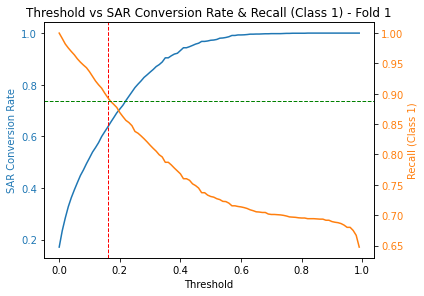

Fold 2: Objective Recall Target = 0.9613


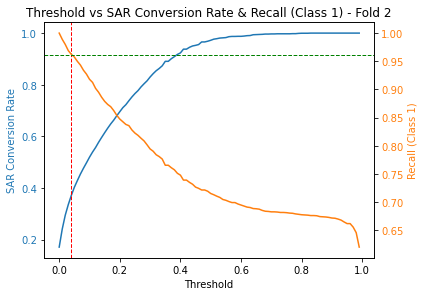

Fold 3: Objective Recall Target = 0.8686


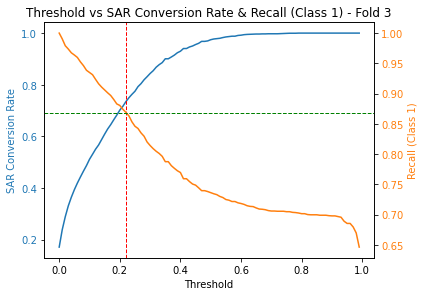

Fold 4: Objective Recall Target = 0.9025


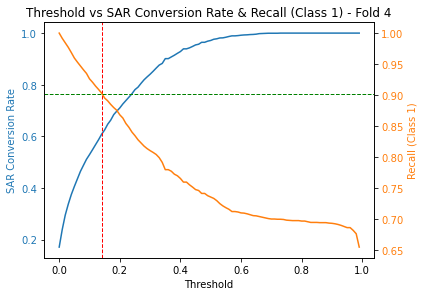

Fold 5: Objective Recall Target = 0.8798


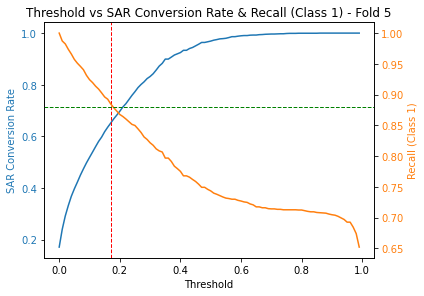

Averaged Optimal Threshold from Cross-Validation: 0.1460
Test Set SAR Conversion Rate at Averaged Threshold: 0.6134
Test Set Recall at Averaged Threshold: 0.8976


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

# Function to calculate SAR Conversion Rate
def sar_conversion_rate(y_true, y_pred):
    positive_predictions = np.sum(y_pred)
    if positive_predictions == 0:
        return 0
    true_positives = np.sum((y_pred == 1) & (y_true == 1))
    return true_positives / positive_predictions

# Dichotomy (binary search) function to find the optimal threshold
def find_optimal_threshold(y_prob, y_true, limit_recall, tol=1e-4):
    low, high = 0.0, 1.0
    best_threshold = 0.5
    while high - low > tol:
        mid = (low + high) / 2.0
        y_pred = (y_prob >= mid).astype(int)
        recall = recall_score(y_true, y_pred)
        
        if recall < limit_recall:
            high = mid
        else:
            best_threshold = mid
            low = mid
            
    return best_threshold

# Cross-validation setup with stratification
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
optimal_thresholds = []

# Cross-validation process
for fold_num, (train_index, val_index) in enumerate(skf.split(X_train, y_train), start=1):
    X_train_fold = X_train.iloc[train_index]
    X_val_fold = X_train.iloc[val_index]
    y_train_fold = y_train.iloc[train_index]
    y_val_fold = y_train.iloc[val_index]
    
    # Train model on the current fold
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train_fold, y_train_fold)
    
    # Predict probabilities on the validation fold
    y_prob_val_fold = model.predict_proba(X_val_fold)[:, 1]
    
    # Calculate SAR Conversion Rate and Recall for each threshold
    thresholds = np.arange(0.0, 1.0, 0.01)
    sar_rates = []
    recalls = []
    for threshold in thresholds:
        y_pred_val = (y_prob_val_fold >= threshold).astype(int)
        sar_rate = sar_conversion_rate(y_val_fold, y_pred_val)
        recall = recall_score(y_val_fold, y_pred_val)
        sar_rates.append(sar_rate)
        recalls.append(recall)
    
    objective_recall = np.random.uniform(min_recall_tuning, 1.0)
    print(f"Fold {fold_num}: Objective Recall Target = {objective_recall:.4f}")
    
    # Find the optimal threshold using the dichotomy method for this fold
    optimal_threshold = find_optimal_threshold(y_prob_val_fold, y_val_fold, objective_recall)
    optimal_thresholds.append(optimal_threshold)

    # Plot SAR Conversion Rate and Recall for each threshold
    fig, ax1 = plt.subplots()

    ax1.set_xlabel('Threshold')
    ax1.set_ylabel('SAR Conversion Rate', color='tab:blue')
    ax1.plot(thresholds, sar_rates, color='tab:blue', label='SAR Conversion Rate')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.set_ylabel('Recall (Class 1)', color='tab:orange')
    ax2.plot(thresholds, recalls, color='tab:orange', label='Recall (Class 1)')
    ax2.tick_params(axis='y', labelcolor='tab:orange')

    # Highlight the selected threshold and the objective recall
    ax1.axvline(x=optimal_threshold, color='red', linestyle='--', linewidth=1, label='Selected Threshold')
    ax2.axhline(y=objective_recall, color='green', linestyle='--', linewidth=1, label='Objective Recall')

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.title(f'Threshold vs SAR Conversion Rate & Recall (Class 1) - Fold {fold_num}')
    plt.show()

# Average the thresholds obtained from all folds
average_threshold = np.mean(optimal_thresholds)
print(f"Averaged Optimal Threshold from Cross-Validation: {average_threshold:.4f}")

# Evaluate on the test set using the averaged threshold
y_prob_test = model.predict_proba(X_test)[:, 1]
y_pred_test = (y_prob_test >= average_threshold).astype(int)
test_sar_conversion = sar_conversion_rate(y_test, y_pred_test)
test_recall = recall_score(y_test, y_pred_test)

print(f"Test Set SAR Conversion Rate at Averaged Threshold: {test_sar_conversion:.4f}")
print(f"Test Set Recall at Averaged Threshold: {test_recall:.4f}")


Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best parameters found:  {'max_depth': 7, 'max_features': 20, 'max_leaf_nodes': 93, 'min_samples_leaf': 271, 'min_samples_split': 108, 'n_estimators': 73}
Fold 1: Objective Recall Target = 0.8664


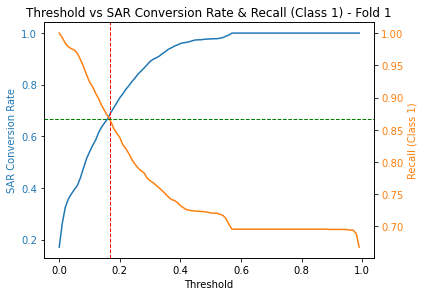

Fold 2: Objective Recall Target = 0.9446


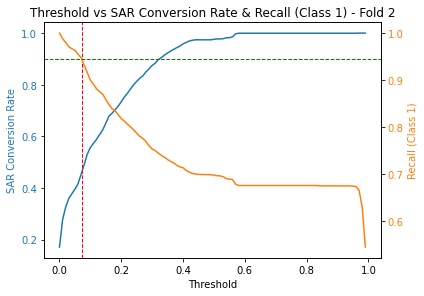

Fold 3: Objective Recall Target = 0.9107


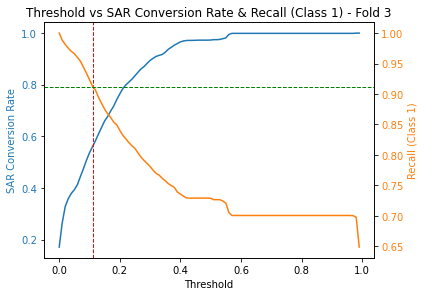

Fold 4: Objective Recall Target = 0.8841


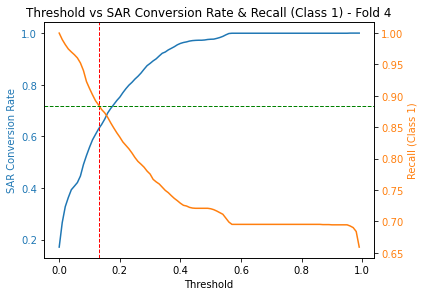

Fold 5: Objective Recall Target = 0.8921


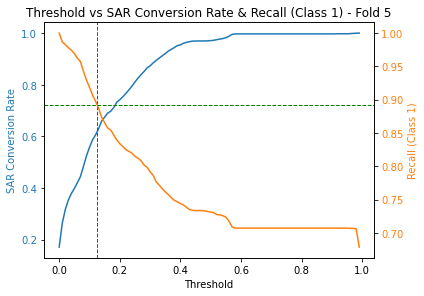

Averaged Optimal Threshold from Cross-Validation: 0.1216
Test Set SAR Conversion Rate at Averaged Threshold: 0.6098
Test Set Recall at Averaged Threshold: 0.8988


In [15]:


# Create the custom scorer for RandomizedSearchCV
recall_scorer = make_scorer(recall_class_1)

# Define your model
model = RandomForestClassifier()

# Define the hyperparameters and their respective distributions to sample from
param_dist = {
    'n_estimators': randint(2, 200),
    'max_depth': randint(1, 20),
    'min_samples_split': randint(2, 500),
    'min_samples_leaf': randint(1, 500),
    'max_features': randint(1, 26),
    'max_leaf_nodes': randint(1, 150)
}

# Set up the RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=2,  # You can increase this number for a more thorough search
    scoring=recall_scorer,  # Scoring based on recall
    n_jobs=-15,
    cv=5,
    verbose=1,
    random_state=42
)

# Fit the model
random_search.fit(X_train, y_train)

# Output the best parameters and the best score from RandomizedSearchCV
print("Best parameters found: ", random_search.best_params_)

# Use the best model found from the RandomizedSearchCV for further steps
best_model = random_search.best_estimator_


# Cross-validation setup with stratification
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
optimal_thresholds = []

# Cross-validation process
for fold_num, (train_index, val_index) in enumerate(skf.split(X_train, y_train), start=1):
    X_train_fold = X_train.iloc[train_index]
    X_val_fold = X_train.iloc[val_index]
    y_train_fold = y_train.iloc[train_index]
    y_val_fold = y_train.iloc[val_index]
    
    # Train the best model on the current fold
    best_model.fit(X_train_fold, y_train_fold)
    
    # Predict probabilities on the validation fold
    y_prob_val_fold = best_model.predict_proba(X_val_fold)[:, 1]
    
    # Calculate SAR Conversion Rate and Recall for each threshold
    thresholds = np.arange(0.0, 1.0, 0.01)
    sar_rates = []
    recalls = []
    for threshold in thresholds:
        y_pred_val = (y_prob_val_fold >= threshold).astype(int)
        sar_rate = sar_conversion_rate(y_val_fold, y_pred_val)
        recall = recall_score(y_val_fold, y_pred_val)
        sar_rates.append(sar_rate)
        recalls.append(recall)
    

    objective_recall = np.random.uniform(min_recall_tuning, 1.0)
    print(f"Fold {fold_num}: Objective Recall Target = {objective_recall:.4f}")
    
    # Find the optimal threshold using the dichotomy method for this fold
    optimal_threshold = find_optimal_threshold(y_prob_val_fold, y_val_fold, objective_recall)
    optimal_thresholds.append(optimal_threshold)

    # Plot SAR Conversion Rate and Recall for each threshold
    fig, ax1 = plt.subplots()

    ax1.set_xlabel('Threshold')
    ax1.set_ylabel('SAR Conversion Rate', color='tab:blue')
    ax1.plot(thresholds, sar_rates, color='tab:blue', label='SAR Conversion Rate')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.set_ylabel('Recall (Class 1)', color='tab:orange')
    ax2.plot(thresholds, recalls, color='tab:orange', label='Recall (Class 1)')
    ax2.tick_params(axis='y', labelcolor='tab:orange')

    # Highlight the selected threshold and the objective recall
    ax1.axvline(x=optimal_threshold, color='red', linestyle='--', linewidth=1, label='Selected Threshold')
    ax2.axhline(y=objective_recall, color='green', linestyle='--', linewidth=1, label='Objective Recall')

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.title(f'Threshold vs SAR Conversion Rate & Recall (Class 1) - Fold {fold_num}')
    plt.show()

# Average the thresholds obtained from all folds
average_threshold = np.mean(optimal_thresholds)
print(f"Averaged Optimal Threshold from Cross-Validation: {average_threshold:.4f}")

# Evaluate on the test set using the averaged threshold
y_prob_test = best_model.predict_proba(X_test)[:, 1]
y_pred_test = (y_prob_test >= average_threshold).astype(int)
test_sar_conversion = sar_conversion_rate(y_test, y_pred_test)
test_recall = recall_score(y_test, y_pred_test)

print(f"Test Set SAR Conversion Rate at Averaged Threshold: {test_sar_conversion:.4f}")
print(f"Test Set Recall at Averaged Threshold: {test_recall:.4f}")


## x.x - Importance de mes variables

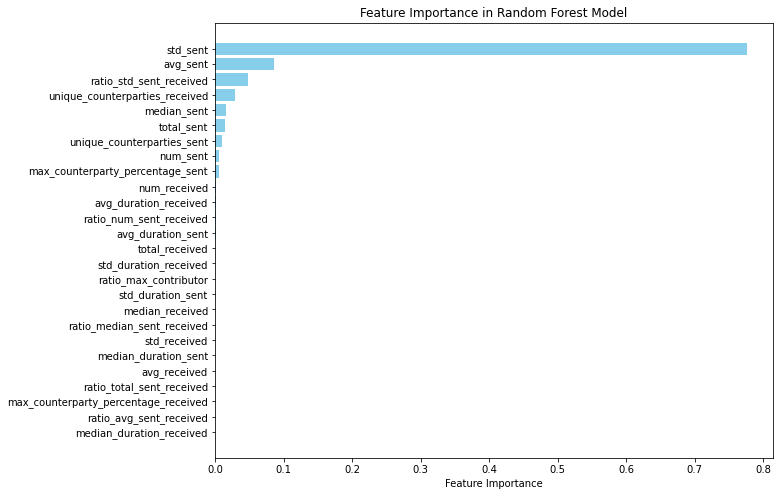

In [16]:
# Assuming best_model is the RandomForest model from the hyperparameter tuning process
importances = best_model.feature_importances_
indices = np.argsort(importances)

# Plotting the feature importances
fig, ax = plt.subplots(figsize=(10, 8))  # You can adjust the figure size as needed
ax.barh(range(len(importances)), importances[indices], color='skyblue')
ax.set_yticks(range(len(importances)))
ax.set_yticklabels(np.array(X_train.columns)[indices])
ax.set_xlabel('Feature Importance')
ax.set_title('Feature Importance in Random Forest Model')
plt.show()

## x.x - Utilisation de SHAP pour mon random forest 

In [49]:
# Attention, cette étape dure un certain temps

explainer = shap.Explainer(best_model.predict,X_test)
shap_values_test = explainer(X_test)

PermutationExplainer explainer: 201it [01:06,  2.50it/s]                                                               


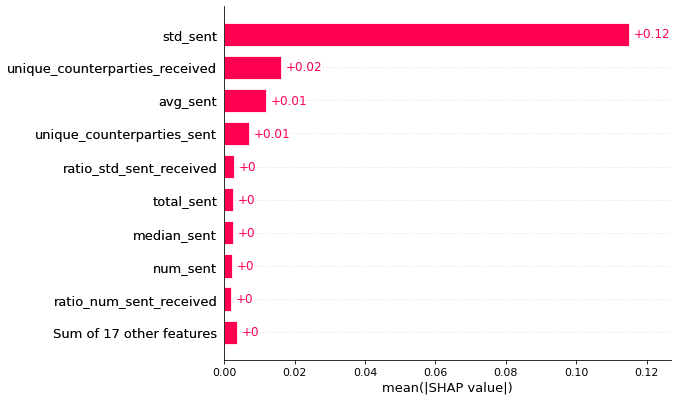

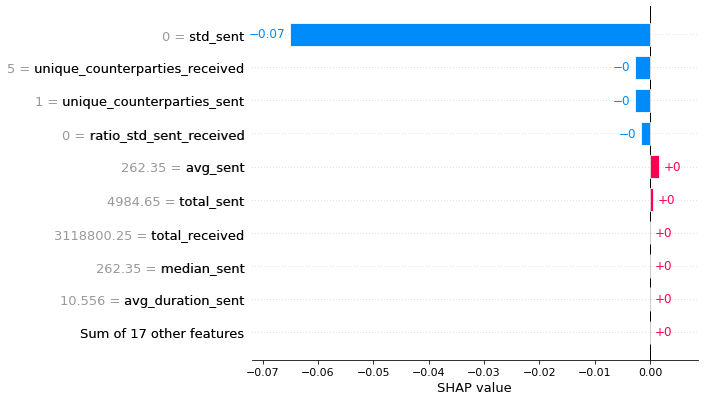

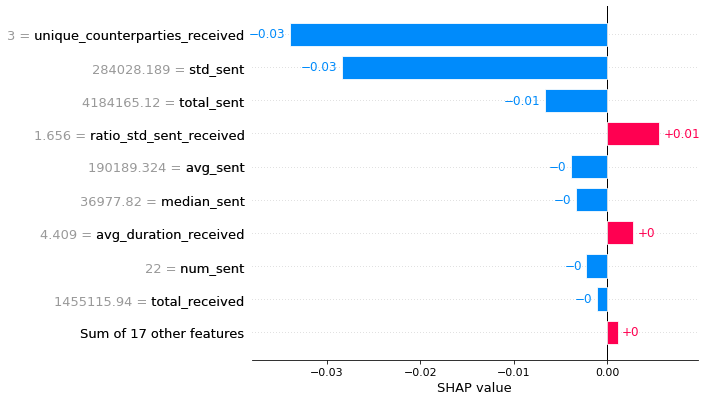

In [61]:
shap.plots.bar(shap_values_test)
shap.plots.bar(shap_values_test[0])
shap.plots.bar(shap_values_test[1])

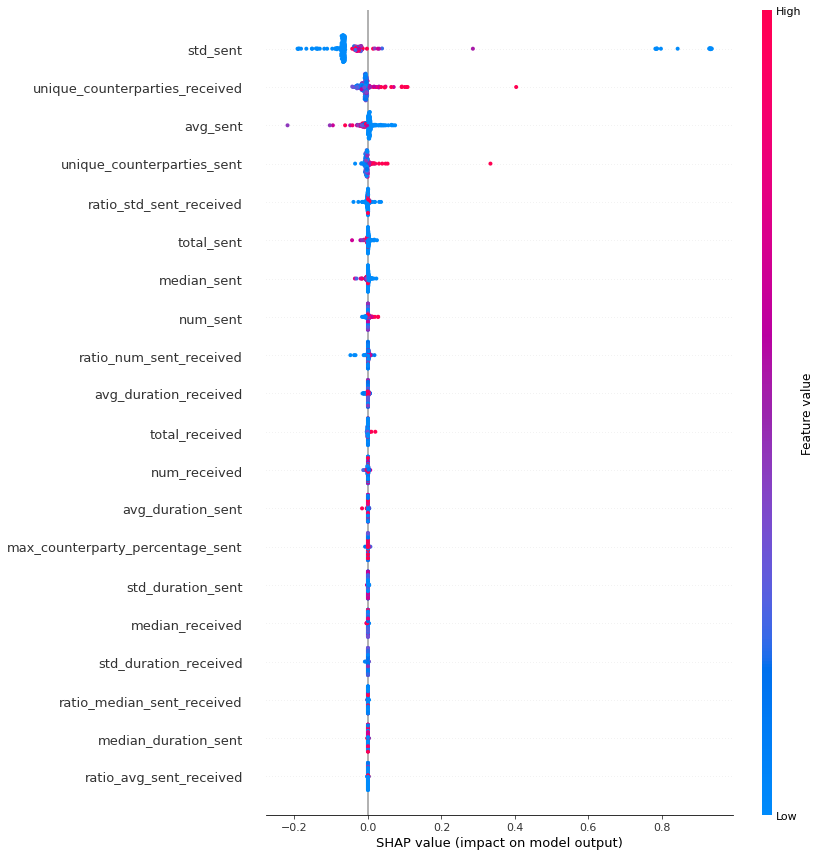

In [67]:
shap.summary_plot(shap_values_test,plot_size = (12,12))

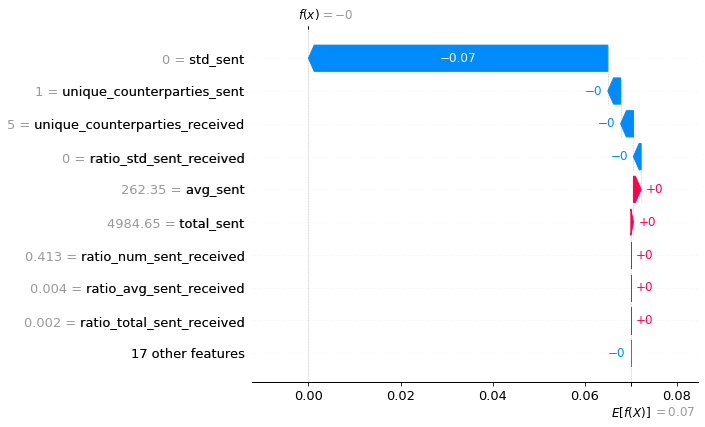

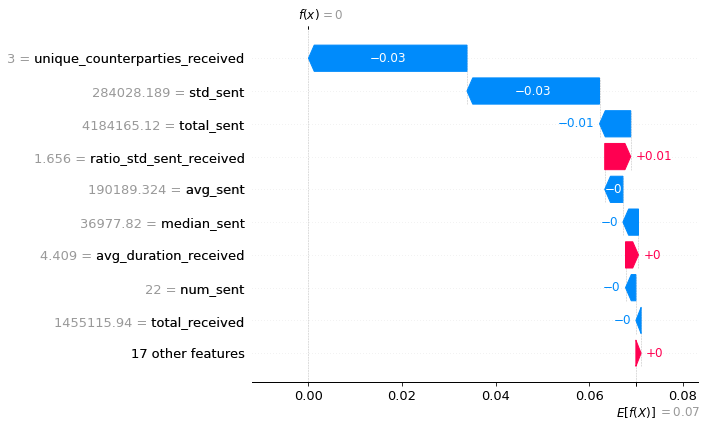

In [70]:
shap.plots.waterfall(shap_values_test[0])
shap.plots.waterfall(shap_values_test[1])

In [65]:
shap.plots.force(shap_values_test)

## 3 - Réseaux de neuronnes

C:\Users\balle\AppData\Local\Temp\ipykernel_8024\508874058.py:16: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, verbose=0)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters found:  {'neurons': 100, 'epochs': 100, 'dropout_rate': 0.3, 'batch_size': 128}
500/500 [==============================] - 1s 1ms/step
Fold 1: Objective Recall Target = 0.9519


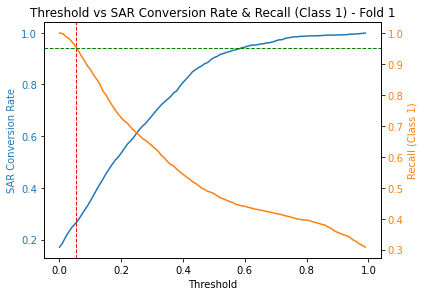

500/500 [==============================] - 1s 1ms/step
Fold 2: Objective Recall Target = 0.8653


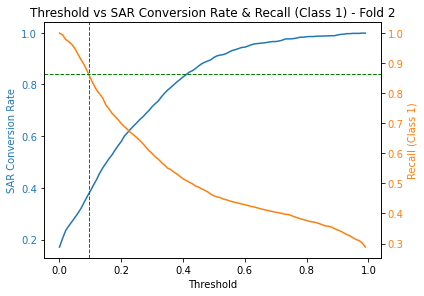

500/500 [==============================] - 1s 1ms/step
Fold 3: Objective Recall Target = 0.9946


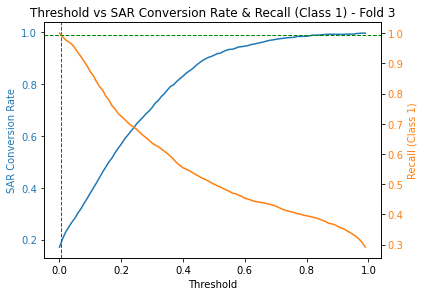

500/500 [==============================] - 1s 1ms/step
Fold 4: Objective Recall Target = 0.8584


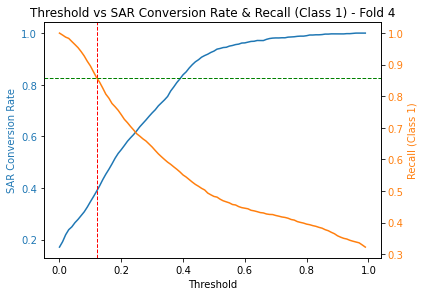

500/500 [==============================] - 1s 1ms/step
Fold 5: Objective Recall Target = 0.9629


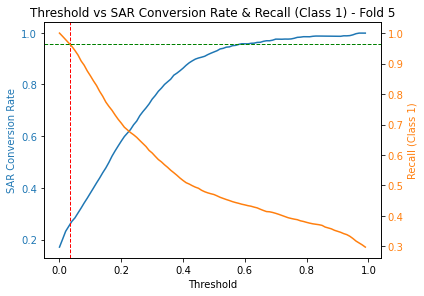

Averaged Optimal Threshold from Cross-Validation: 0.0619
625/625 [==============================] - 1s 1ms/step
Test Set SAR Conversion Rate at Averaged Threshold: 0.3072
Test Set Recall at Averaged Threshold: 0.9295


In [7]:
# Create the custom scorer for RandomizedSearchCV
recall_scorer = make_scorer(recall_class_1)

# Define a function to create the MLP model
def create_model(neurons=50, dropout_rate=0.2):
    model = Sequential()
    model.add(Dense(neurons, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy')
    return model

# Wrap the Keras model for use in Scikit-learn
model = KerasClassifier(build_fn=create_model, verbose=0)

# Define the hyperparameters and their respective distributions to sample from
param_dist = {
    'neurons': [50, 100, 150],
    'dropout_rate': [0.2, 0.3, 0.4],
    'batch_size': [32, 64, 128],
    'epochs': [10, 50, 100],
}

# Set up the RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=10,  # You can increase this number for a more thorough search
    scoring=recall_scorer,
    n_jobs=-1,
    cv=5,
    verbose=1,
    random_state=42
)

# Fit the model
random_search.fit(X_train_scaled, y_train)

# Output the best parameters and the best score from RandomizedSearchCV
print("Best parameters found: ", random_search.best_params_)

# Use the best model found from the RandomizedSearchCV for further steps
best_model = random_search.best_estimator_

# Cross-validation setup with stratification
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
optimal_thresholds = []

# Cross-validation process
for fold_num, (train_index, val_index) in enumerate(skf.split(X_train, y_train), start=1):
    X_train_fold = X_train_scaled[train_index]
    X_val_fold = X_train_scaled[val_index]
    y_train_fold = y_train.iloc[train_index]
    y_val_fold = y_train.iloc[val_index]
    
    # Train the best model on the current fold
    best_model.fit(X_train_fold, y_train_fold)
    
    # Predict probabilities on the validation fold
    y_prob_val_fold = best_model.predict_proba(X_val_fold)[:, 1]
    
    # Calculate SAR Conversion Rate and Recall for each threshold
    thresholds = np.arange(0.0, 1.0, 0.01)
    sar_rates = []
    recalls = []
    for threshold in thresholds:
        y_pred_val = (y_prob_val_fold >= threshold).astype(int)
        sar_rate = conversion_rate(y_val_fold, y_pred_val)
        recall = recall_score(y_val_fold, y_pred_val)
        sar_rates.append(sar_rate)
        recalls.append(recall)

    objective_recall = np.random.uniform(min_recall_tuning, 1.0)
    print(f"Fold {fold_num}: Objective Recall Target = {objective_recall:.4f}")
    
    # Find the optimal threshold using the dichotomy method for this fold
    optimal_threshold = find_optimal_threshold(y_prob_val_fold, y_val_fold, objective_recall)
    optimal_thresholds.append(optimal_threshold)

    # Plot SAR Conversion Rate and Recall for each threshold
    fig, ax1 = plt.subplots()

    ax1.set_xlabel('Threshold')
    ax1.set_ylabel('SAR Conversion Rate', color='tab:blue')
    ax1.plot(thresholds, sar_rates, color='tab:blue', label='SAR Conversion Rate')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.set_ylabel('Recall (Class 1)', color='tab:orange')
    ax2.plot(thresholds, recalls, color='tab:orange', label='Recall (Class 1)')
    ax2.tick_params(axis='y', labelcolor='tab:orange')

    # Highlight the selected threshold and the objective recall
    ax1.axvline(x=optimal_threshold, color='red', linestyle='--', linewidth=1, label='Selected Threshold')
    ax2.axhline(y=objective_recall, color='green', linestyle='--', linewidth=1, label='Objective Recall')

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.title(f'Threshold vs SAR Conversion Rate & Recall (Class 1) - Fold {fold_num}')
    plt.show()

# Average the thresholds obtained from all folds
average_threshold = np.mean(optimal_thresholds)
print(f"Averaged Optimal Threshold from Cross-Validation: {average_threshold:.4f}")

# Evaluate on the test set using the averaged threshold
y_prob_test = best_model.predict_proba(X_test_scaled)[:, 1]
y_pred_test = (y_prob_test >= average_threshold).astype(int)
test_sar_conversion = conversion_rate(y_test, y_pred_test)
test_recall = recall_score(y_test, y_pred_test)

print(f"Test Set SAR Conversion Rate at Averaged Threshold: {test_sar_conversion:.4f}")
print(f"Test Set Recall at Averaged Threshold: {test_recall:.4f}")

In [14]:
# Attention, cette étape dure un certain temps

mlp_explainer = shap.Explainer(mlp_best_model.predict,X_test_scaled[:100])
mlp_shap_values_test = mlp_explainer(X_test_scaled[:100])

83/83 [==============================] - 0s 1ms/step


PermutationExplainer explainer:   4%|██▎                                                       | 4/100 [00:00<?, ?it/s]

84/84 [==============================] - 0s 1ms/step


PermutationExplainer explainer:   6%|███                                               | 6/100 [00:12<01:56,  1.24s/it]

84/84 [==============================] - 0s 990us/step


PermutationExplainer explainer:   7%|███▌                                              | 7/100 [00:14<02:37,  1.69s/it]

82/82 [==============================] - 0s 897us/step


PermutationExplainer explainer:   8%|████                                              | 8/100 [00:17<02:55,  1.91s/it]

84/84 [==============================] - 0s 1ms/step


PermutationExplainer explainer:   9%|████▌                                             | 9/100 [00:19<03:06,  2.05s/it]

83/83 [==============================] - 0s 972us/step


PermutationExplainer explainer:  10%|████▉                                            | 10/100 [00:21<03:11,  2.13s/it]

83/83 [==============================] - 0s 1ms/step


PermutationExplainer explainer:  11%|█████▍                                           | 11/100 [00:24<03:24,  2.30s/it]

84/84 [==============================] - 0s 1ms/step


PermutationExplainer explainer:  12%|█████▉                                           | 12/100 [00:27<03:33,  2.43s/it]

84/84 [==============================] - 0s 1ms/step


PermutationExplainer explainer:  13%|██████▎                                          | 13/100 [00:29<03:31,  2.43s/it]

81/81 [==============================] - 0s 1ms/step


PermutationExplainer explainer:  14%|██████▊                                          | 14/100 [00:31<03:27,  2.41s/it]

84/84 [==============================] - 0s 963us/step


PermutationExplainer explainer:  15%|███████▎                                         | 15/100 [00:34<03:22,  2.38s/it]

82/82 [==============================] - 0s 1ms/step


PermutationExplainer explainer:  16%|███████▊                                         | 16/100 [00:36<03:17,  2.35s/it]

82/82 [==============================] - 0s 1ms/step


PermutationExplainer explainer:  17%|████████▎                                        | 17/100 [00:38<03:13,  2.33s/it]

83/83 [==============================] - 0s 1ms/step


PermutationExplainer explainer:  18%|████████▊                                        | 18/100 [00:41<03:09,  2.31s/it]

83/83 [==============================] - 0s 1ms/step


PermutationExplainer explainer:  19%|█████████▎                                       | 19/100 [00:43<03:05,  2.29s/it]

84/84 [==============================] - 0s 949us/step


PermutationExplainer explainer:  20%|█████████▊                                       | 20/100 [00:45<03:02,  2.28s/it]

84/84 [==============================] - 0s 1ms/step


PermutationExplainer explainer:  21%|██████████▎                                      | 21/100 [00:48<03:04,  2.34s/it]

81/81 [==============================] - 0s 1ms/step


PermutationExplainer explainer:  22%|██████████▊                                      | 22/100 [00:50<03:00,  2.31s/it]

82/82 [==============================] - 0s 1ms/step


PermutationExplainer explainer:  23%|███████████▎                                     | 23/100 [00:52<02:57,  2.31s/it]

83/83 [==============================] - 0s 1ms/step


PermutationExplainer explainer:  24%|███████████▊                                     | 24/100 [00:54<02:55,  2.30s/it]

83/83 [==============================] - 0s 1ms/step


PermutationExplainer explainer:  25%|████████████▎                                    | 25/100 [00:57<02:51,  2.29s/it]

83/83 [==============================] - 0s 1ms/step


PermutationExplainer explainer:  26%|████████████▋                                    | 26/100 [00:59<02:50,  2.30s/it]

82/82 [==============================] - 0s 989us/step


PermutationExplainer explainer:  27%|█████████████▏                                   | 27/100 [01:01<02:50,  2.33s/it]

82/82 [==============================] - 0s 992us/step


PermutationExplainer explainer:  28%|█████████████▋                                   | 28/100 [01:04<02:47,  2.33s/it]

84/84 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  29%|██████████████▏                                  | 29/100 [01:06<02:47,  2.36s/it]

84/84 [==============================] - 0s 1ms/step


PermutationExplainer explainer:  30%|██████████████▋                                  | 30/100 [01:09<02:45,  2.37s/it]

84/84 [==============================] - 0s 1ms/step


PermutationExplainer explainer:  31%|███████████████▏                                 | 31/100 [01:11<02:44,  2.38s/it]

83/83 [==============================] - 0s 973us/step


PermutationExplainer explainer:  32%|███████████████▋                                 | 32/100 [01:13<02:42,  2.38s/it]

83/83 [==============================] - 0s 1ms/step


PermutationExplainer explainer:  33%|████████████████▏                                | 33/100 [01:16<02:36,  2.33s/it]

83/83 [==============================] - 0s 852us/step


PermutationExplainer explainer:  34%|████████████████▋                                | 34/100 [01:18<02:32,  2.31s/it]

84/84 [==============================] - 0s 843us/step


PermutationExplainer explainer:  35%|█████████████████▏                               | 35/100 [01:21<02:38,  2.43s/it]

84/84 [==============================] - 0s 1ms/step


PermutationExplainer explainer:  36%|█████████████████▋                               | 36/100 [01:23<02:35,  2.44s/it]

84/84 [==============================] - 0s 926us/step


PermutationExplainer explainer:  37%|██████████████████▏                              | 37/100 [01:26<02:36,  2.48s/it]

83/83 [==============================] - 0s 1ms/step


PermutationExplainer explainer:  38%|██████████████████▌                              | 38/100 [01:28<02:29,  2.41s/it]

84/84 [==============================] - 0s 950us/step


PermutationExplainer explainer:  39%|███████████████████                              | 39/100 [01:30<02:26,  2.39s/it]

84/84 [==============================] - 0s 969us/step


PermutationExplainer explainer:  40%|███████████████████▌                             | 40/100 [01:33<02:27,  2.45s/it]

84/84 [==============================] - 0s 966us/step


PermutationExplainer explainer:  41%|████████████████████                             | 41/100 [01:35<02:22,  2.41s/it]

84/84 [==============================] - 0s 906us/step


PermutationExplainer explainer:  42%|████████████████████▌                            | 42/100 [01:38<02:20,  2.43s/it]

84/84 [==============================] - 0s 1ms/step


PermutationExplainer explainer:  43%|█████████████████████                            | 43/100 [01:40<02:20,  2.47s/it]

84/84 [==============================] - 0s 1ms/step


PermutationExplainer explainer:  44%|█████████████████████▌                           | 44/100 [01:43<02:18,  2.48s/it]

84/84 [==============================] - 0s 964us/step


PermutationExplainer explainer:  45%|██████████████████████                           | 45/100 [01:45<02:17,  2.50s/it]

84/84 [==============================] - 0s 966us/step


PermutationExplainer explainer:  46%|██████████████████████▌                          | 46/100 [01:48<02:12,  2.45s/it]

82/82 [==============================] - 0s 937us/step


PermutationExplainer explainer:  47%|███████████████████████                          | 47/100 [01:50<02:04,  2.35s/it]

82/82 [==============================] - 0s 989us/step


PermutationExplainer explainer:  48%|███████████████████████▌                         | 48/100 [01:52<02:00,  2.32s/it]

84/84 [==============================] - 0s 1ms/step


PermutationExplainer explainer:  49%|████████████████████████                         | 49/100 [01:54<02:00,  2.37s/it]

81/81 [==============================] - 0s 998us/step


PermutationExplainer explainer:  50%|████████████████████████▌                        | 50/100 [01:57<01:58,  2.38s/it]

84/84 [==============================] - 0s 1ms/step


PermutationExplainer explainer:  51%|████████████████████████▉                        | 51/100 [01:59<01:56,  2.37s/it]

83/83 [==============================] - 0s 1ms/step


PermutationExplainer explainer:  52%|█████████████████████████▍                       | 52/100 [02:02<01:54,  2.38s/it]

83/83 [==============================] - 0s 985us/step


PermutationExplainer explainer:  53%|█████████████████████████▉                       | 53/100 [02:04<01:51,  2.37s/it]

83/83 [==============================] - 0s 850us/step


PermutationExplainer explainer:  54%|██████████████████████████▍                      | 54/100 [02:06<01:48,  2.36s/it]

83/83 [==============================] - 0s 972us/step


PermutationExplainer explainer:  55%|██████████████████████████▉                      | 55/100 [02:08<01:43,  2.29s/it]

84/84 [==============================] - 0s 879us/step


PermutationExplainer explainer:  56%|███████████████████████████▍                     | 56/100 [02:11<01:40,  2.29s/it]

84/84 [==============================] - 0s 1ms/step


PermutationExplainer explainer:  57%|███████████████████████████▉                     | 57/100 [02:13<01:40,  2.33s/it]

79/79 [==============================] - 0s 1ms/step


PermutationExplainer explainer:  58%|████████████████████████████▍                    | 58/100 [02:15<01:39,  2.37s/it]

82/82 [==============================] - 0s 1ms/step


PermutationExplainer explainer:  59%|████████████████████████████▉                    | 59/100 [02:18<01:36,  2.36s/it]

84/84 [==============================] - 0s 964us/step


PermutationExplainer explainer:  60%|█████████████████████████████▍                   | 60/100 [02:20<01:34,  2.37s/it]

84/84 [==============================] - 0s 952us/step


PermutationExplainer explainer:  61%|█████████████████████████████▉                   | 61/100 [02:23<01:33,  2.41s/it]

82/82 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  62%|██████████████████████████████▍                  | 62/100 [02:25<01:31,  2.41s/it]

84/84 [==============================] - 0s 1ms/step


PermutationExplainer explainer:  63%|██████████████████████████████▊                  | 63/100 [02:28<01:29,  2.41s/it]

83/83 [==============================] - 0s 933us/step


PermutationExplainer explainer:  64%|███████████████████████████████▎                 | 64/100 [02:30<01:24,  2.35s/it]

82/82 [==============================] - 0s 989us/step


PermutationExplainer explainer:  65%|███████████████████████████████▊                 | 65/100 [02:32<01:23,  2.37s/it]

80/80 [==============================] - 0s 1ms/step


PermutationExplainer explainer:  66%|████████████████████████████████▎                | 66/100 [02:34<01:19,  2.33s/it]

83/83 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  67%|████████████████████████████████▊                | 67/100 [02:37<01:16,  2.31s/it]

83/83 [==============================] - 0s 1ms/step


PermutationExplainer explainer:  68%|█████████████████████████████████▎               | 68/100 [02:39<01:13,  2.28s/it]

83/83 [==============================] - 0s 852us/step


PermutationExplainer explainer:  69%|█████████████████████████████████▊               | 69/100 [02:41<01:10,  2.27s/it]

83/83 [==============================] - 0s 1ms/step


PermutationExplainer explainer:  70%|██████████████████████████████████▎              | 70/100 [02:43<01:07,  2.25s/it]

82/82 [==============================] - 0s 986us/step


PermutationExplainer explainer:  71%|██████████████████████████████████▊              | 71/100 [02:46<01:05,  2.27s/it]

84/84 [==============================] - 0s 992us/step


PermutationExplainer explainer:  72%|███████████████████████████████████▎             | 72/100 [02:48<01:03,  2.28s/it]

83/83 [==============================] - 0s 836us/step


PermutationExplainer explainer:  73%|███████████████████████████████████▊             | 73/100 [02:50<01:02,  2.30s/it]

83/83 [==============================] - 0s 863us/step


PermutationExplainer explainer:  74%|████████████████████████████████████▎            | 74/100 [02:52<00:57,  2.23s/it]

84/84 [==============================] - 0s 960us/step


PermutationExplainer explainer:  75%|████████████████████████████████████▊            | 75/100 [02:55<00:56,  2.24s/it]

84/84 [==============================] - 0s 972us/step


PermutationExplainer explainer:  76%|█████████████████████████████████████▏           | 76/100 [02:57<00:53,  2.25s/it]

84/84 [==============================] - 0s 822us/step


PermutationExplainer explainer:  77%|█████████████████████████████████████▋           | 77/100 [03:00<00:54,  2.36s/it]

84/84 [==============================] - 0s 951us/step


PermutationExplainer explainer:  78%|██████████████████████████████████████▏          | 78/100 [03:02<00:51,  2.33s/it]

83/83 [==============================] - 0s 1ms/step


PermutationExplainer explainer:  79%|██████████████████████████████████████▋          | 79/100 [03:04<00:48,  2.32s/it]

82/82 [==============================] - 0s 953us/step


PermutationExplainer explainer:  80%|███████████████████████████████████████▏         | 80/100 [03:06<00:45,  2.27s/it]

84/84 [==============================] - 0s 976us/step


PermutationExplainer explainer:  81%|███████████████████████████████████████▋         | 81/100 [03:08<00:42,  2.24s/it]

83/83 [==============================] - 0s 912us/step


PermutationExplainer explainer:  82%|████████████████████████████████████████▏        | 82/100 [03:11<00:39,  2.21s/it]

82/82 [==============================] - 0s 972us/step


PermutationExplainer explainer:  83%|████████████████████████████████████████▋        | 83/100 [03:13<00:38,  2.25s/it]

84/84 [==============================] - 0s 966us/step


PermutationExplainer explainer:  84%|█████████████████████████████████████████▏       | 84/100 [03:15<00:36,  2.27s/it]

83/83 [==============================] - 0s 1ms/step


PermutationExplainer explainer:  85%|█████████████████████████████████████████▋       | 85/100 [03:18<00:34,  2.29s/it]

84/84 [==============================] - 0s 1ms/step


PermutationExplainer explainer:  86%|██████████████████████████████████████████▏      | 86/100 [03:20<00:34,  2.45s/it]

84/84 [==============================] - 0s 930us/step


PermutationExplainer explainer:  87%|██████████████████████████████████████████▋      | 87/100 [03:23<00:31,  2.42s/it]

83/83 [==============================] - 0s 974us/step


PermutationExplainer explainer:  88%|███████████████████████████████████████████      | 88/100 [03:25<00:28,  2.35s/it]

84/84 [==============================] - 0s 985us/step


PermutationExplainer explainer:  89%|███████████████████████████████████████████▌     | 89/100 [03:27<00:25,  2.34s/it]

83/83 [==============================] - 0s 961us/step


PermutationExplainer explainer:  90%|████████████████████████████████████████████     | 90/100 [03:30<00:23,  2.32s/it]

84/84 [==============================] - 0s 929us/step


PermutationExplainer explainer:  91%|████████████████████████████████████████████▌    | 91/100 [03:32<00:21,  2.35s/it]

84/84 [==============================] - 0s 995us/step


PermutationExplainer explainer:  92%|█████████████████████████████████████████████    | 92/100 [03:34<00:18,  2.36s/it]

84/84 [==============================] - 0s 932us/step


PermutationExplainer explainer:  93%|█████████████████████████████████████████████▌   | 93/100 [03:37<00:16,  2.34s/it]

84/84 [==============================] - 0s 967us/step


PermutationExplainer explainer:  94%|██████████████████████████████████████████████   | 94/100 [03:39<00:14,  2.38s/it]

81/81 [==============================] - 0s 1ms/step


PermutationExplainer explainer:  95%|██████████████████████████████████████████████▌  | 95/100 [03:41<00:11,  2.36s/it]

84/84 [==============================] - 0s 1ms/step


PermutationExplainer explainer:  96%|███████████████████████████████████████████████  | 96/100 [03:44<00:09,  2.40s/it]

83/83 [==============================] - 0s 972us/step


PermutationExplainer explainer:  97%|███████████████████████████████████████████████▌ | 97/100 [03:46<00:07,  2.36s/it]

84/84 [==============================] - 0s 965us/step


PermutationExplainer explainer:  98%|████████████████████████████████████████████████ | 98/100 [03:48<00:04,  2.32s/it]

83/83 [==============================] - 0s 955us/step


PermutationExplainer explainer:  99%|████████████████████████████████████████████████▌| 99/100 [03:51<00:02,  2.29s/it]

82/82 [==============================] - 0s 987us/step


PermutationExplainer explainer: 100%|████████████████████████████████████████████████| 100/100 [03:53<00:00,  2.25s/it]

82/82 [==============================] - 0s 865us/step


PermutationExplainer explainer: 101it [03:55,  2.43s/it]                                                               


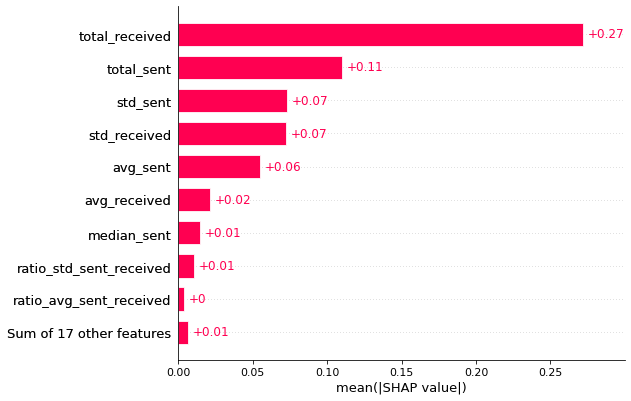

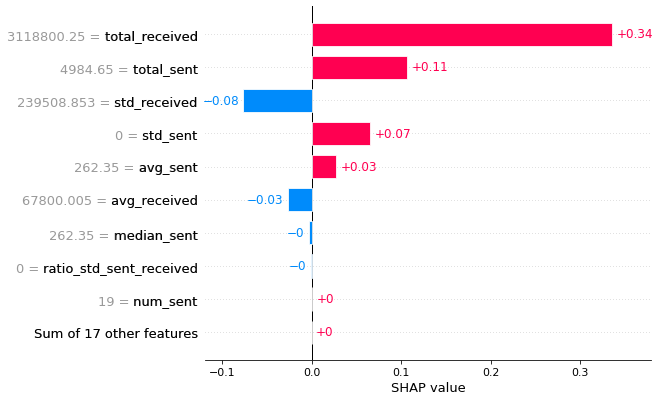

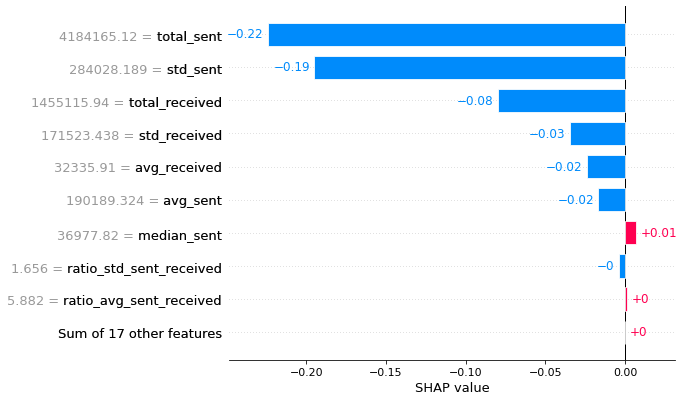

In [9]:
shap.plots.bar(shap_values_test)
shap.plots.bar(shap_values_test[0])
shap.plots.bar(shap_values_test[1])